## Classify heart disease using patients' age, maximum heart rate during strenuous exercise, and ST depression induced by exercise

### Introduction

Heart disease *(cardiovascular disease)* encompasses various conditions affecting the heart and blood vessels, often leading to heart attacks due to arterial blockages. Early identification and treatment are crucial to prevent severe complications. 

The *Heart Attack dataset* used provides 13 variables that are possibly linked to heart disease, with whether or not they developed the disease. This study aims **uses the K-nearest neighbors (KNN) algorithm to predict heart disease likelihood**, focusingno* *age, maximum heart rate, and exercise-induced ST depresoi*n 

Scientifically, age is a key factor, especially in those aged 65 and older. Low maximum heart rate and ST depression are early heart disease symptoms. Reduced maximum heart rate indicates lower cardiovascular fitness, while ST depression on an electrocardiogram signals potential issues like myocardial ischemia.

Thus, the question being addressed is: **Can heart disease be accurately predicted based on a patient’s age, maximum heart rate during strenuous exercise, and ST depression induced by exercise?**


### Preliminary exploratory data analysis

In [1]:
#Import libraries and set seed to 1
library(tidyverse)
library(tidymodels)
library(repr)
set.seed(1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#Reading the dataframe from file
heart_data <- read_csv("Heart Attack Data Set.csv")
head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1


In [3]:
# Cleaning, warngling data
heart_clean_data <- heart_data |>
        mutate(target = as_factor(target))|>     
        mutate(target = fct_recode(target, "True" = "1", "False" = "0")) |> #Change target to factor TRUE/FALSE
        mutate(sex = as.factor(as.integer(sex)), cp = as.factor(as.integer(cp)), 
               fbs = as.factor(as.integer(fbs)), restecg = as.factor(as.integer(restecg)),
               exang = as.factor(as.integer(exang)), thal = as.factor(as.integer(thal)),
               ca = as.factor(as.integer(ca)), slope = as.factor(as.integer(slope)))  
head(heart_clean_data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,3,145,233,1,0,150,0,2.3,0,0,1,True
37,1,2,130,250,0,1,187,0,3.5,0,0,2,True
41,0,1,130,204,0,0,172,0,1.4,2,0,2,True
56,1,1,120,236,0,1,178,0,0.8,2,0,2,True
57,0,0,120,354,0,1,163,1,0.6,2,0,2,True
57,1,0,140,192,0,1,148,0,0.4,1,0,1,True


In [4]:
# Splitting dataframe into training, testing datasets
heart_split <- initial_split(heart_clean_data, prop = 0.75, strata = target)

heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

In [5]:
#Exploratory data analysis
heart_ana <- heart_training |>
             group_by(target) |>
             summarize(n_of_obs = n(),
                       mean_age = mean(age),
                       mean_thalach = mean(thalach),
                       mean_oldpeak= mean(oldpeak),
                       missing_rows= sum(is.na(~.)))

heart_ana

Warning message:
“There were 2 warnings in `summarize()`.
The first warning was:
ℹ In argument: `missing_rows = sum(is.na(~.))`.
ℹ In group 1: `target = False`.
Caused by warning in `is.na()`:
! is.na() applied to non-(list or vector) of type 'language'
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


target,n_of_obs,mean_age,mean_thalach,mean_oldpeak,missing_rows
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>
False,103,56.06796,139.9417,1.5825243,0
True,123,53.50407,155.9756,0.6455285,0


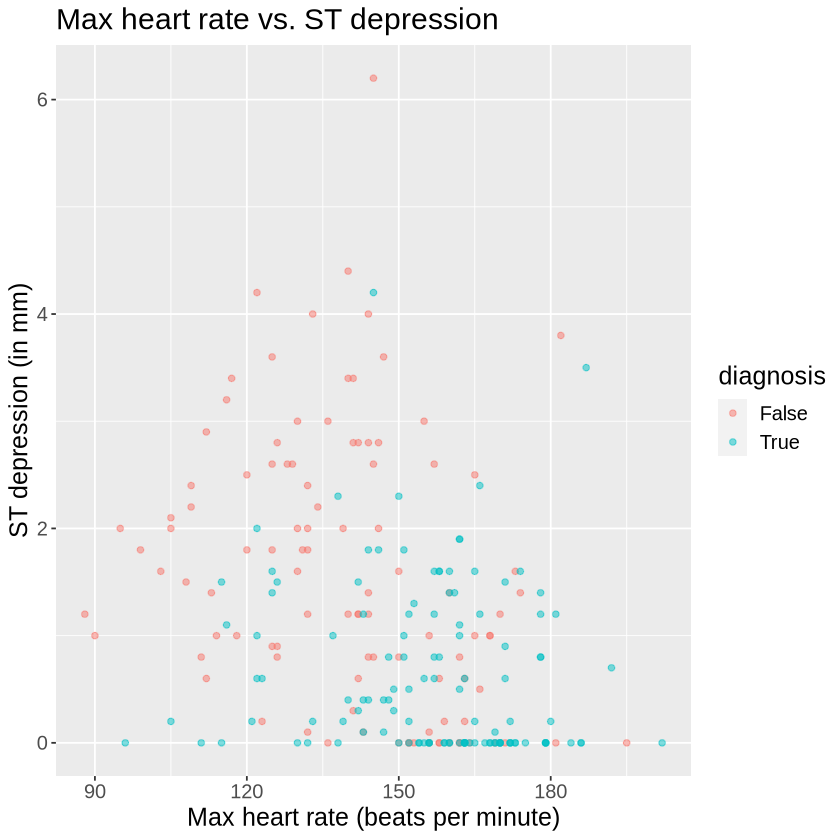

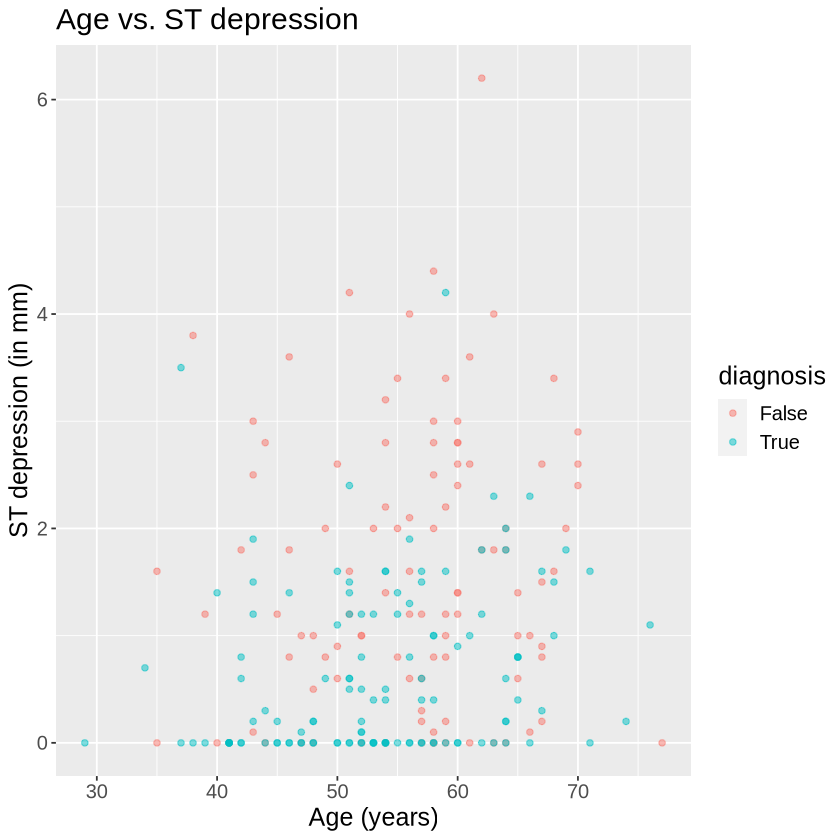

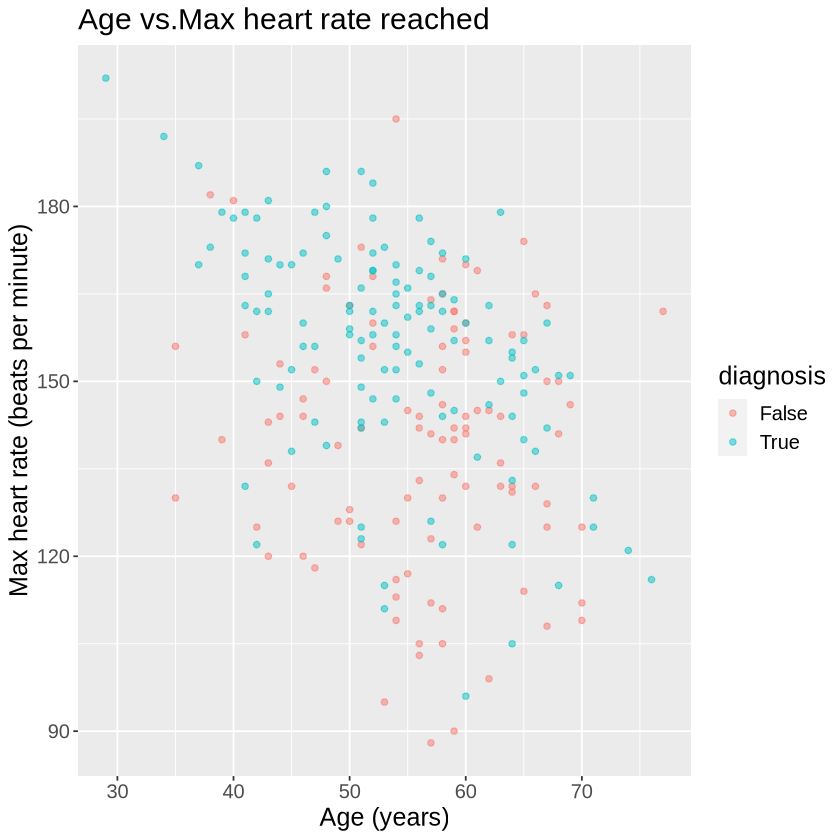

In [6]:
#plotting the training data
plot1 <- ggplot(heart_training, aes(x = thalach, y = oldpeak, color = target)) +
            geom_point(alpha = 0.5) +
            labs(x = "Max heart rate (beats per minute)", y = "ST depression (in mm)", color = "diagnosis", title = "Max heart rate vs. ST depression") +
            theme(text = element_text(size = 15))

plot2 <- ggplot(heart_training, aes(x = age, y = oldpeak, color = target)) +
             geom_point(alpha = 0.5) +
             labs(x = "Age (years)", y = "ST depression (in mm)", color = "diagnosis", , title = "Age vs. ST depression") +
             theme(text = element_text(size = 15)) 

plot3 <- ggplot(heart_training, aes(x = age, y = thalach, color = target)) +
             geom_point(alpha = 0.5) +
             labs(x = "Age (years)", y = "Max heart rate (beats per minute)", color = "diagnosis", title = "Age vs.Max heart rate reached") +
             theme(text = element_text(size = 15)) 

# Plot the three graphs
plot1
plot2
plot3

### Method

We are using the *Heart Attack Data Set* for predicting The columns we are using for predcting heart disease. The columns contains  303 rows and 13 attributes, all in `double` data type:
1. **age**: age
2. **sex**: sex (1 = male, 0 = female)
3. **cp**: chest pain type
4. **trestbps**: resting blood pressure (in mmHg)
5. **chol**: serum cholestoral (in mg/dl)
6. **fbs**: fasting blood sugar > 120 mg/dl? (1 = True, 0 = False)
7. **restecg**: resting electrocardiographic results
8. **thalach**: maximum heart rate archieved
9. **exang**: whether exercise induced angina (1 = True, 0 = False)
10. **oldpeak**: ST depression induced by exercise, relative to rest
11. **slope**: the slope of the peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope)
12. **ca**: number of major vessels (0-3) colored by flourosopy
13. **thal**: (3 = normal, 6 = fixed defect, 7 = reversable defect)
14. **num**: diagnosis of heart disease (1,2,3,4 = presence, 0 = no presence)sence, 0 = no presence)f observations.

We start by **importing the dataset into Jupyter Notebook**. To make the original `csv` file accessible to all team members, we download it and upload it to GitHub. Afterward, we can retrieve the dataset from the remote repository and read it from the local repository using the `read_csv` function, as demonstrated above.

**Data Cleaning**
Before analyzing stage, we need to make the dataset tidy after reading the file, making it easier to analyze. We assign appropriate data types to each variable by changing categorical variables (sex, cp, ...) into *factor* while keeping the numerical variables *double*. Also, for *target*, we changed 1,0 to "True" (Disease) and "False" (No Disease) to make it more legible.

**Data Splitting**
After tidying, we utilize `initial_split()` to partition the data into 75% training and 25% testing data, ensuring a stratified split based on the target variable.

**Data Summary**
Using the training set, we consider the mean values of three predictors mentioned in the predictive question above to study the distribution of observations for each class (Disease and No Disease), along with the observation count and number of NA values. The summarize table shows no NA values and nearly equal observations in each class. Notably, *oldpeak* appears higher for those without heart disease, and *MHR* is smaller, consistent with trends discussed in the *Introduction part*. However, the *age* variable suggests a slightly smaller age for heart patients. 
 To better decide thefficienceff and distributint of the predictors for our KNN model, we then use visualization.

**Data Visualization**
We created three scatter plots to see the data distribution. The different target are colored and we included clear titles to make the visualization more understandable. Be wary of overplotting, we used `geom_point(alpha=0.5)` for *ST depression* to address overlapping issues caused by numerous zero values. All plots exhibit distinct regions for both classes and remains informative despite many zero values in ST depression.


### Expected outcomes and significance